In [1]:
import scanpy as sc
import pandas as pd
import diffxpy.api as de
import numpy as np
import patsy
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import upsetplot as usp
from matplotlib import rcParams
from diffxpy.testing.det import DifferentialExpressionTestWald
import matplotlib.cm as cm
import matplotlib as mpl
from sklearn.preprocessing import minmax_scale
from anndata import AnnData
from sklearn.linear_model import LinearRegression, LogisticRegression
import meld
import graphtools
from sklearn.preprocessing import  OneHotEncoder

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/data_exploration/')
import helper_diffxpy as hde
import importlib
importlib.reload(hde)
import helper_diffxpy as hde
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h


In [3]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_gene_groups='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/moransi/sfintegrated/'
path_save='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/de_diseased_T2_VSGSTZ_meld_covarStudy/'

In [4]:
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [5]:
adata_b_rn=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')

## Prepare data

### Subset data

In [6]:
adata_b_rn.shape

(102143, 30672)

Do not use low quality cluster. Use only VSG and STZ studies

In [7]:
studies=['VSG','STZ' ]
samples=adata_b_rn.obs.query('study in @studies').study_sample.unique().tolist()
print('N samples to use',len(samples))
print(samples)

N samples to use 15
['VSG_MUC13640', 'VSG_MUC13639', 'VSG_MUC13633', 'VSG_MUC13634', 'VSG_MUC13641', 'VSG_MUC13631', 'VSG_MUC13642', 'VSG_MUC13632', 'STZ_G2', 'STZ_G8', 'STZ_G5', 'STZ_G1', 'STZ_G6', 'STZ_G4', 'STZ_G3']


In [8]:
# Subset 
# Samples to use
adata_b_rn_sub=adata_b_rn[adata_b_rn.obs.study_sample.isin(samples),:].copy()
# Clusters
adata_b_rn_sub=adata_b_rn_sub[ ~adata_b_rn_sub.obs['leiden_r1.5'].isin(['19','20']),
                          :].copy()
print(adata_b_rn_sub.shape)
print(adata_b_rn_sub.obs.study_sample_design.unique().tolist())
print(adata_b_rn_sub.obs['leiden_r1.5'].unique().tolist())

(44153, 30672)
['VSG_MUC13640_VSG_Lepr-/-', 'VSG_MUC13639_sham_Lepr-/-', 'VSG_MUC13633_chow_WT', 'VSG_MUC13634_chow_WT', 'VSG_MUC13641_sham_Lepr-/-', 'VSG_MUC13631_PF_Lepr-/-', 'VSG_MUC13642_VSG_Lepr-/-', 'VSG_MUC13632_PF_Lepr-/-', 'STZ_G2_STZ', 'STZ_G8_STZ_GLP-1_estrogen+insulin', 'STZ_G5_STZ_estrogen', 'STZ_G1_control', 'STZ_G6_STZ_GLP-1_estrogen', 'STZ_G4_STZ_GLP-1', 'STZ_G3_STZ_insulin']
['4', '11', '0', '21', '6', '2', '3', '10', '12', '8', '7', '9', '5', '16', '13', '14', '1', '17', '15', '22', '18']


In [9]:
# recompute subsetted visualisation
sc.pp.neighbors(adata_b_rn_sub,n_pcs=0,use_rep='X_integrated')
sc.tl.umap(adata_b_rn_sub)

Trying to set attribute `.uns` of view, copying.


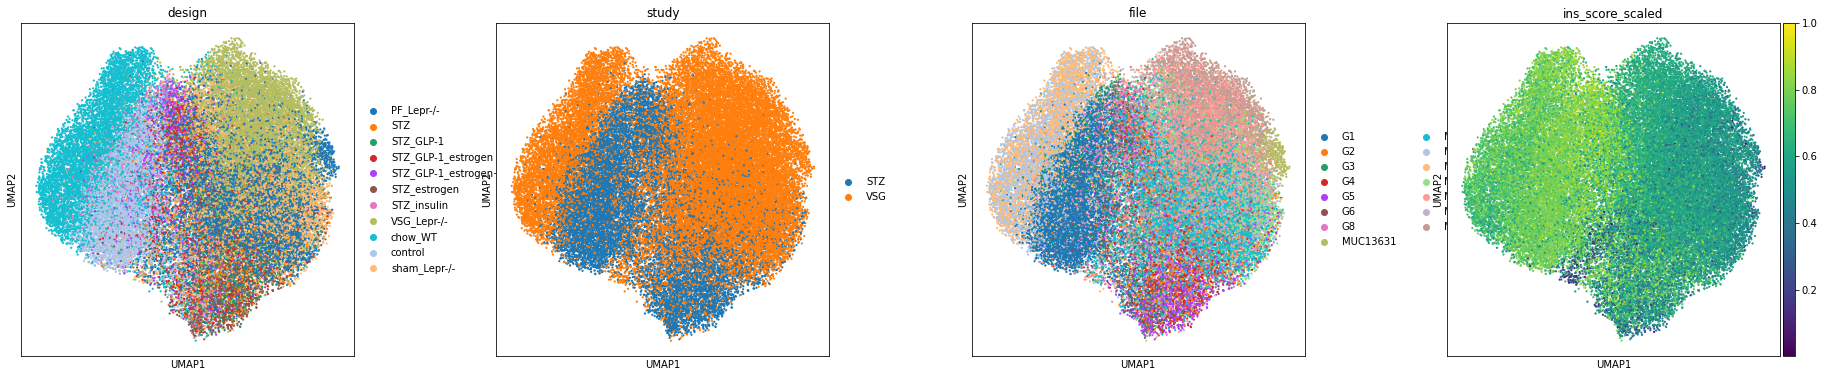

In [10]:
rcParams['figure.figsize']=(6,6)
random_indices=np.random.permutation(list(range(adata_b_rn_sub.shape[0])))
sc.pl.umap(adata_b_rn_sub[random_indices,:],
           color=['design','study','file','ins_score_scaled'],s=20,sort_order=False,wspace=0.3)

### MELD

In [11]:
# Prepare MELD object
meld_obj=meld.MELD()
meld_obj.X=adata_b_rn_sub.obsm['X_integrated']
# Make MELD graph
meld_obj=meld_obj.fit(graphtools.Graph(
    adata_b_rn_sub.obsp['connectivities'], precomputed="adjacency"))

In [12]:
# Make categories for meld - e.g. healthy or diseased per study, ignore treated (drop NA)
status_meld_map={
 'VSG_MUC13639_sham_Lepr-/-':'VSG_diabetic',
 'VSG_MUC13633_chow_WT':'VSG_healthy',
 'VSG_MUC13634_chow_WT':'VSG_healthy',
 'VSG_MUC13641_sham_Lepr-/-':'VSG_diabetic',
 'STZ_G2_STZ':'STZ_diabetic',
 'STZ_G1_control':'STZ_healthy'}
status_meld=adata_b_rn_sub.obs.study_sample_design.map(status_meld_map).\
    fillna('NA').astype('category')
status_meld=pd.DataFrame(
    OneHotEncoder(categories=[status_meld.cat.categories.tolist()]).\
    fit_transform(np.array(status_meld).reshape(-1,1)).todense(),
    index=adata_b_rn_sub.obs_names,columns=status_meld.cat.categories.tolist()
    ).drop('NA',axis=1)

In [13]:
# Compute MELD
adata_b_rn_sub.obs.drop([col for col in adata_b_rn_sub.obs.columns if 'meld_' in col],
                       axis=1,inplace=True)
for col in status_meld.columns:
    adata_b_rn_sub.obs['meld_'+col+'_raw']=meld_obj.transform(status_meld[col])[1].values
# Normalize over all meld scores
adata_b_rn_sub.obs[
    [col.replace('_raw','') for col in adata_b_rn_sub.obs.columns if 'meld_' in col]]=\
    meld.utils.normalize_densities(
        adata_b_rn_sub.obs[[col for col in adata_b_rn_sub.obs.columns if 'meld_' in col]])

In [14]:
# Make mean over healthy and diseased studies
for condition in ['healthy','diabetic']:
    # Raw
    adata_b_rn_sub.obs['meld_'+condition+'_raw']=adata_b_rn_sub.obs[[
        'meld_'+col+'_raw' for col in status_meld.columns 
        if condition in col ]
        ].mean(axis=1)
    # Normalized
    adata_b_rn_sub.obs['meld_'+condition]=adata_b_rn_sub.obs[[
        'meld_'+col for col in status_meld.columns 
        if condition in col ]
        ].mean(axis=1)

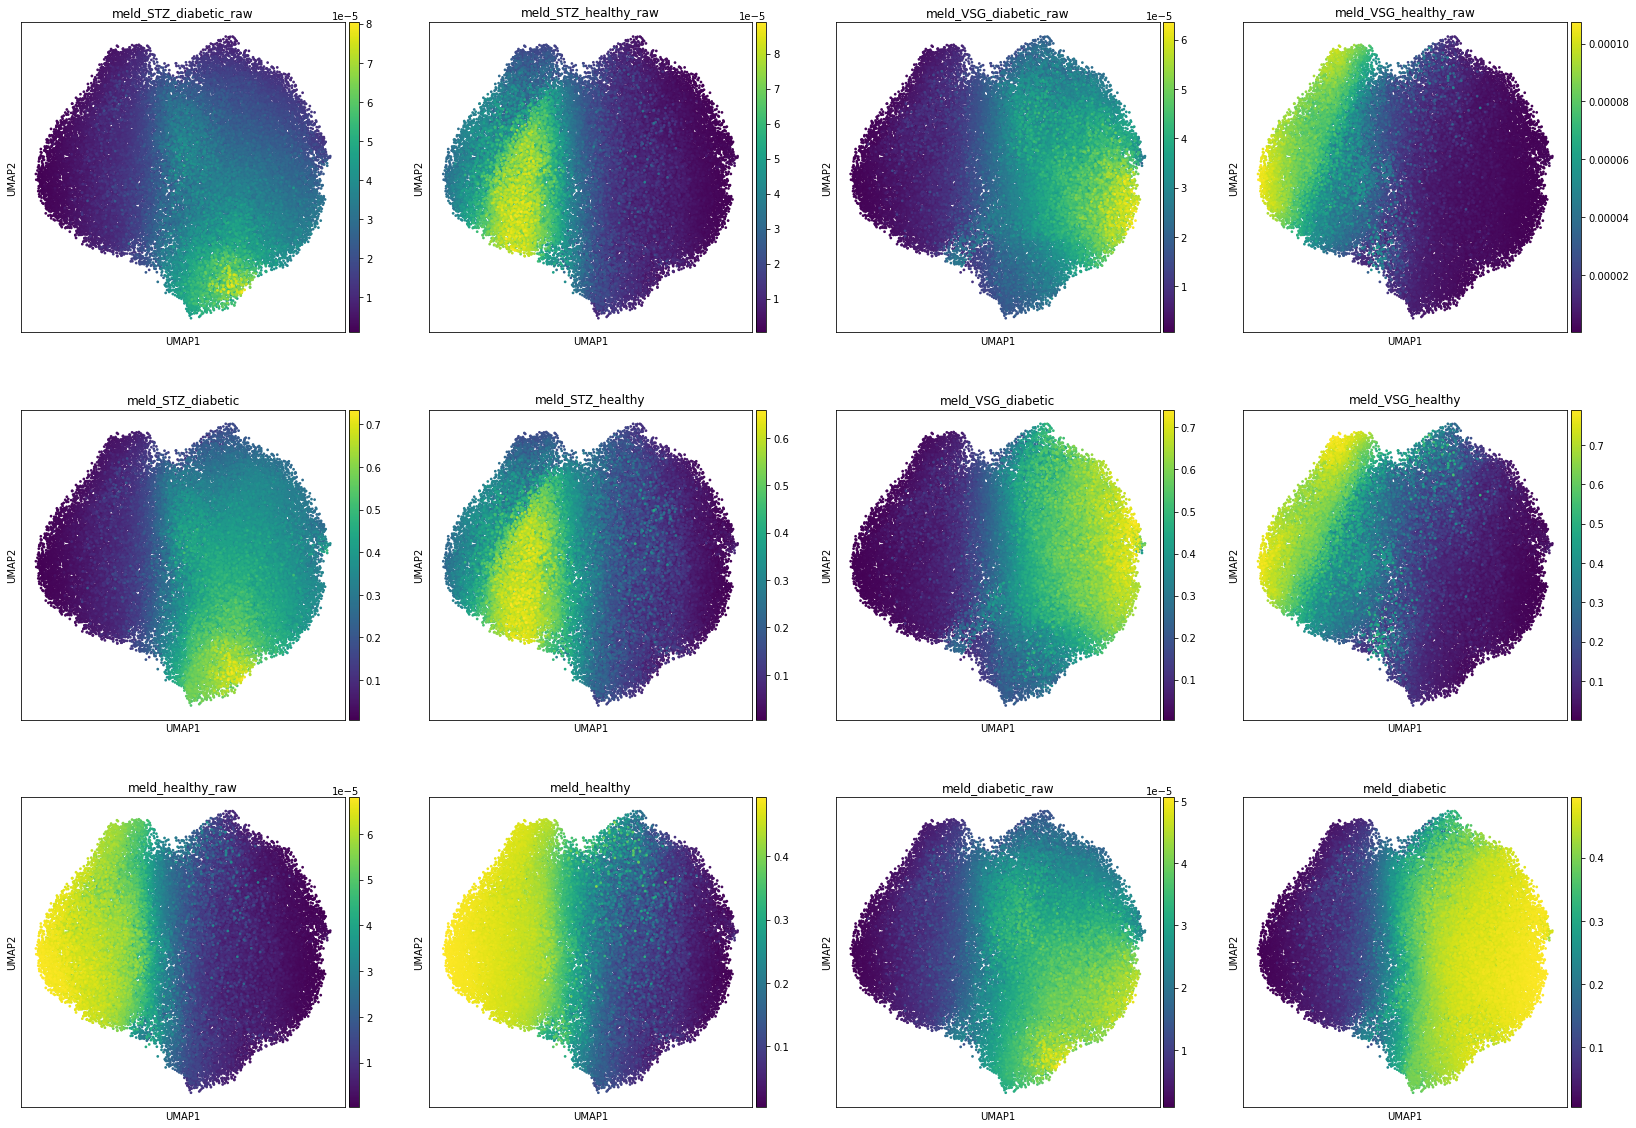

In [15]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_b_rn_sub,color=[col for col in adata_b_rn_sub.obs.columns if 'meld_' in col],
          s=30)

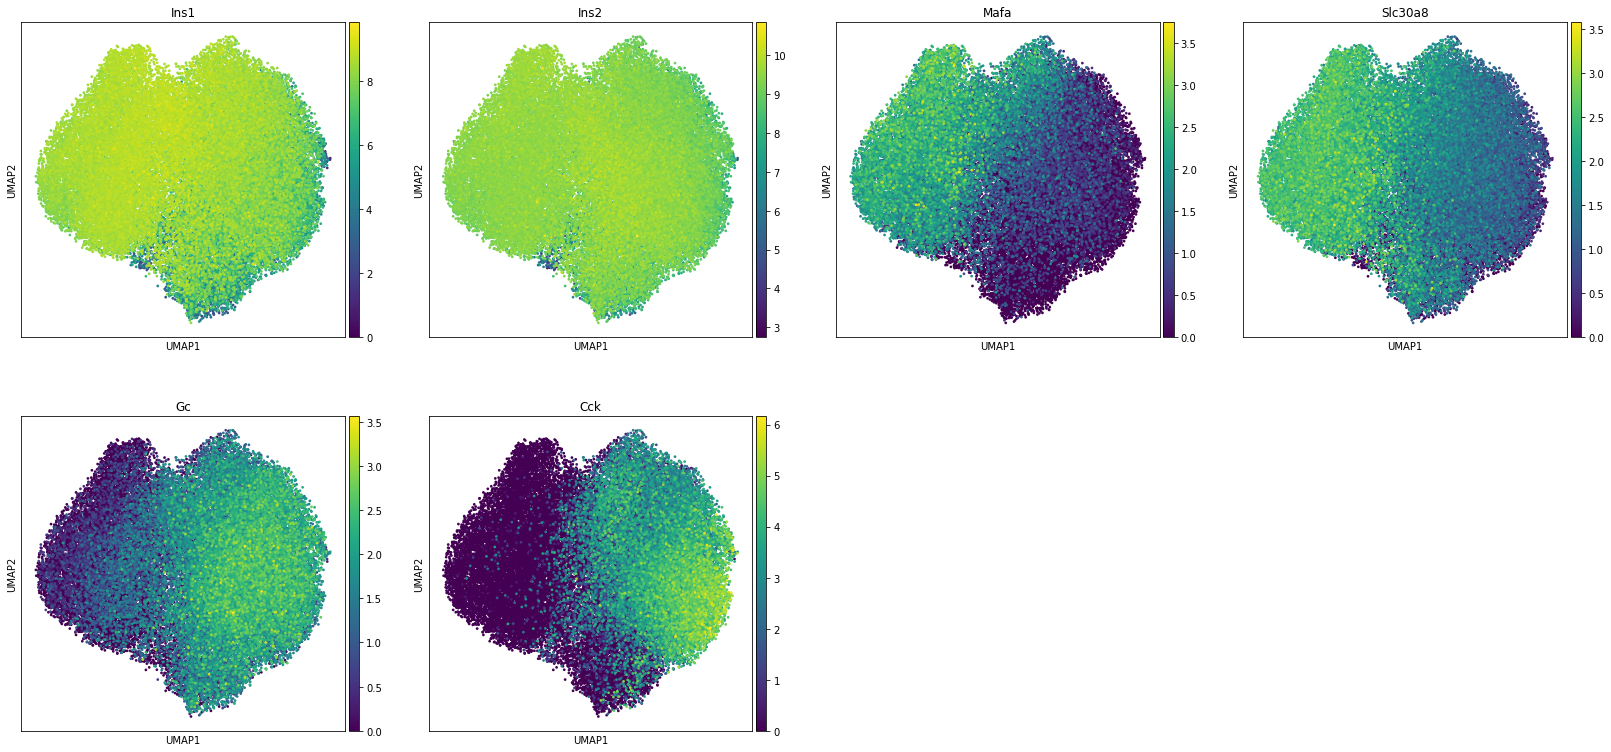

In [17]:
# Plot some markers for comparison
sc.pl.umap(adata_b_rn_sub,color=['Ins1','Ins2','Mafa','Slc30a8','Gc','Cck'],gene_symbols='gene_symbol',
          s=30)

C: As we do normalisation the healthy and diseased are mirror images of each other.

In [18]:
# Make MELD process for DE
# Scale process to [0,1] to be comparable with the T2D one
adata_b_rn_sub.obs['meld_process']=minmax_scale(adata_b_rn_sub.obs['meld_healthy']*-1)

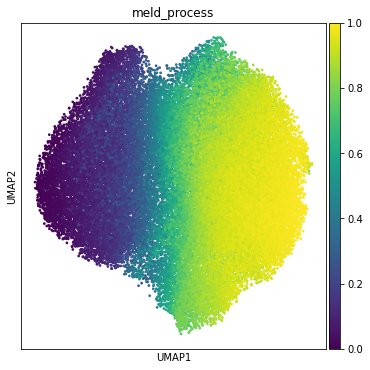

In [19]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_b_rn_sub,color='meld_process', s=30)

In [20]:
# Save meld process
pd.DataFrame(adata_b_rn_sub.obs['meld_process'],
                index=adata_b_rn_sub.obs_names,
                columns=['meld_process']).to_csv(path_save+'process_MELD.tsv',sep='\t')

#### Plot of design info

In [10]:
# reload meld
#adata_b_rn_sub.obs['meld_process']=pd.read_table(
#    path_save+'process_MELD.tsv',index_col=0)['meld_process']

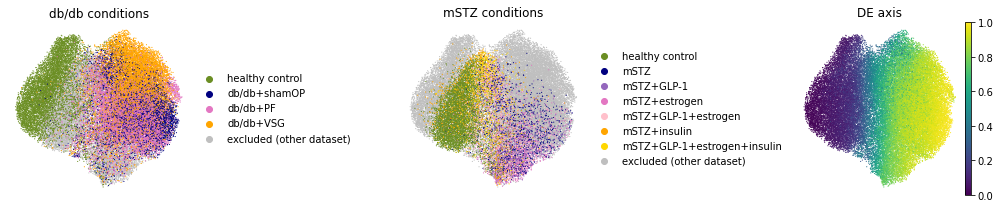

In [71]:
# Set colors 
# VSG design
if 'db/db conditions' in adata_b_rn_sub.obs.columns:
    adata_b_rn_sub.obs.drop('db/db conditions', axis=1,inplace=True)
cells=adata_b_rn_sub.obs.query('study=="VSG"').index
adata_b_rn_sub.obs.loc[cells,'db/db conditions']=adata_b_rn_sub.obs.loc[cells,'design'].map({
    'VSG_Lepr-/-':'db/db+VSG','sham_Lepr-/-':'db/db+shamOP','chow_WT':'healthy control',
     'PF_Lepr-/-':'db/db+PF'}).astype(str)
adata_b_rn_sub.obs['db/db conditions'].fillna('excluded (other dataset)',inplace=True)
cmap={
    'healthy control':'olivedrab','db/db+shamOP':'navy',
    'db/db+PF':'tab:pink','db/db+VSG':'orange',
    'excluded (other dataset)':'#bfbfbf'}
adata_b_rn_sub.uns['db/db conditions_colors']=list(cmap.values())
adata_b_rn_sub.obs['db/db conditions']=pd.Categorical(
    values=adata_b_rn_sub.obs['db/db conditions'],
    categories=list(cmap.keys()),ordered=True)
# STZ design
if 'mSTZ conditions' in adata_b_rn_sub.obs.columns:
    adata_b_rn_sub.obs.drop('mSTZ conditions', axis=1,inplace=True)
cells=adata_b_rn_sub.obs.query('study=="STZ"').index
adata_b_rn_sub.obs.loc[cells,'mSTZ conditions']=adata_b_rn_sub.obs.loc[cells,'design'].apply(
    lambda x:x.replace("STZ",'mSTZ').replace('_','+').replace('control','healthy control')
    ).astype(str)
adata_b_rn_sub.obs['mSTZ conditions'].fillna('excluded (other dataset)',inplace=True)
cmap={
    'healthy control':'olivedrab','mSTZ':'navy',
    'mSTZ+GLP-1':'tab:purple','mSTZ+estrogen':'tab:pink','mSTZ+GLP-1+estrogen':'pink',
    'mSTZ+insulin':'orange','mSTZ+GLP-1+estrogen+insulin':'gold',
    'excluded (other dataset)':'#bfbfbf'}
adata_b_rn_sub.uns['mSTZ conditions_colors']=list(cmap.values())
adata_b_rn_sub.obs['mSTZ conditions']=pd.Categorical(
    values=adata_b_rn_sub.obs['mSTZ conditions'],
    categories=list(cmap.keys()),ordered=True)
# Plot
fig,axs=plt.subplots(1,3,figsize=(14,3))
np.random.seed(0)
# Sort non-excluded cells on top (randomly order them) and excluded cells on the bottom
random_indices=list(adata_b_rn_sub.obs.query('study!="VSG"').index
            )+list(np.random.permutation(list(adata_b_rn_sub.obs.query('study=="VSG"').index)))
sc.pl.umap(adata_b_rn_sub[random_indices,:],
             color=['db/db conditions'],
             s=5, frameon=False,show=False,ax=axs[0])
random_indices=list(adata_b_rn_sub.obs.query('study!="STZ"').index
            )+list(np.random.permutation(list(adata_b_rn_sub.obs.query('study=="STZ"').index)))
sc.pl.umap(adata_b_rn_sub[random_indices,:],
             color=['mSTZ conditions'],
             s=5, frameon=False,show=False, ax=axs[1])
# randomly sort all cells
random_indices=list(np.random.permutation(list(adata_b_rn_sub.obs_names)))
sc.pl.umap(adata_b_rn_sub[random_indices,:],
             color=['meld_process'],title='DE axis',
             s=5, frameon=False,show=False, wspace=0.8,sort_order=False,ax=axs[2])
fig.subplots_adjust(hspace=0, wspace=0.7)
fig.tight_layout()
plt.savefig(path_fig+'umap_beta_VSGSTZ_DEdesign.png',dpi=300,bbox_inches='tight')

## DE test

In [21]:
# Get raw expression data for DE testing, subsetting by cells
adata_b_raw_sub=sc.read( path_data+'data_integrated_analysed_beta_v1s1.h5ad'
    ).raw.to_adata()[ adata_b_rn_sub.obs_names,:].copy()
print(adata_b_raw_sub.shape)

(44153, 30672)


In [33]:
# Add obs info for testing to raw
adata_b_raw_sub.obs=adata_b_rn_sub.obs[['size_factors_integrated','meld_process',
                                        'study_sample_design','study']].copy()
adata_b_raw_sub.obs['status_meld']=adata_b_raw_sub.obs.study_sample_design.map(status_meld_map
                                                                              ).fillna('NA')

Expression filtering of genes - keep genes that are expressed in either healthy or diseased groups used for MELD

In [34]:
min_cells_ratio=0.05

In [35]:
# prepare adata
# Data for testing
adata=adata_b_raw_sub.copy()
# Select expressed genes in partition
cells_healthy=adata.obs.query('status_meld.str.contains("healthy")',engine='python').index
cells_diabetic=adata.obs.query('status_meld.str.contains("diabetic")',engine='python').index
expressed=np.array((adata[cells_healthy,:].X.todense()>0).sum(axis=0)>=
         cells_healthy.shape[0]*min_cells_ratio).ravel()|\
       np.array((adata[cells_diabetic,:].X.todense()>0).sum(axis=0)>=
         cells_diabetic.shape[0]*min_cells_ratio).ravel()
adata=adata[:,expressed]
print('Data after expression filtering:',adata.shape)

Data after expression filtering: (44153, 11149)


### Design and DE

In [37]:
dmat_loc=pd.DataFrame(index=adata.obs_names)
dmat_loc['Intercept']=1

#process of interest
process='meld_process'
dmat_loc[process]=adata.obs[process]

# Study
cov='study'
for c in sorted(adata.obs[cov].unique())[:-1]:
    dmat_loc.loc[adata.obs_names[adata.obs[cov]==c],cov+'_'+c]=1

dmat_loc=dmat_loc.fillna(0)
dmat_loc=dmat_loc.astype('float')

print('dmat_loc')
display(dmat_loc)

dmat_scale=pd.DataFrame(dmat_loc['Intercept'])
constraints_scale=None
constraints_loc=None

coef_to_test=process

dmat_loc


Intercept  meld_process  study_STZ
AAACCCAAGCGCTGAA-1-MUC13640-VSG        1.0      0.940398        0.0
AAACCCAAGGTGCTTT-1-MUC13640-VSG        1.0      0.569606        0.0
AAACCCACAATCCTAG-1-MUC13640-VSG        1.0      0.863423        0.0
AAACCCACACCATTCC-1-MUC13640-VSG        1.0      0.806812        0.0
AAACCCACAGGGCTTC-1-MUC13640-VSG        1.0      0.913026        0.0
...                                    ...           ...        ...
TTTGTCACACGAGGTA-1-G3-STZ              1.0      0.219293        1.0
TTTGTCAGTTGTGGCC-1-G3-STZ              1.0      0.416015        1.0
TTTGTCATCACATACG-1-G3-STZ              1.0      0.775746        1.0
TTTGTCATCGAATCCA-1-G3-STZ              1.0      0.138859        1.0
TTTGTCATCTGTCTAT-1-G3-STZ              1.0      0.454279        1.0

[44153 rows x 3 columns]

In [38]:
if True:
    # Compute result
    result=de.test.wald(
        data=adata,
        coef_to_test=coef_to_test,
        dmat_loc=dmat_loc,
        dmat_scale=dmat_scale,
        constraints_loc=constraints_loc,
        constraints_scale=constraints_scale,
        # Use integarted sf
        size_factors=adata.obs.size_factors_integrated
        )

    # Add design info to result
    result.dmat_loc=dmat_loc
    result.dmat_scale=dmat_scale
    result.constraints_loc=constraints_loc
    result.constraints_scale=constraints_scale
    result.coef_loc_totest_name=coef_to_test

    # save result
    pickle.dump(result, 
        open(path_save+'healthyDiseased_minCellsRatio'+str(min_cells_ratio)+'.pkl', 
                     "wb" ))

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/batchglm/models/base_glm/utils.py:158: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  np.mean(x[np.where(grouping == g)[0], :], axis=0)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/batchglm/models/base_glm/utils.py:171: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_larg

training location model: True
training scale model: True
iter   0: ll=32546129313.634003
iter   1: ll=32194112533.409363, converged: 0.00% (loc: 56.15%, scale update: False), in 62.81sec
iter   2: ll=32063495220.899124, converged: 0.00% (loc: 56.15%, scale update: False), in 27.00sec
iter   3: ll=32032441462.451408, converged: 0.00% (loc: 56.15%, scale update: False), in 28.49sec
iter   4: ll=32028150837.115986, converged: 0.00% (loc: 56.16%, scale update: False), in 27.67sec
iter   5: ll=32027794122.813995, converged: 0.00% (loc: 56.27%, scale update: False), in 27.55sec
iter   6: ll=531370117.324448, converged: 0.00% (loc: 0.00%, scale update: True), in 1151.11sec
iter   7: ll=505192732.100688, converged: 0.00% (loc: 0.13%, scale update: False), in 60.80sec
iter   8: ll=495127541.763803, converged: 0.00% (loc: 0.23%, scale update: False), in 54.74sec
iter   9: ll=493315621.351810, converged: 0.00% (loc: 1.80%, scale update: False), in 58.17sec
iter  10: ll=493223739.989094, converged

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/dask/array/core.py:2894: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


## Analyse DE data

In [39]:
# Loada data
result=pickle.load(
    open(path_save+'healthyDiseased_minCellsRatio'+str(min_cells_ratio)+'.pkl','rb'))

summary=result.summary()
summary.index=summary.gene

### DE result vs gene expression information

In [40]:
# Empirical lFC
c2=np.argmax(adata_b_rn_sub.obs['meld_process'])
c1=np.argmin(adata_b_rn_sub.obs['meld_process'])
result.empirical_log2fc=pd.Series(np.asarray(np.log2(
     (adata_b_rn_sub[c2,summary.gene].X/
    adata_b_rn_sub[c2,summary.gene].obs['size_factors_integrated'].values)/
     (adata_b_rn_sub[c1,summary.gene].X/
      adata_b_rn_sub[c1,summary.gene].obs['size_factors_integrated'].values)
    )).ravel(), index=summary.gene).replace(np.inf,np.nan)

<ipython-input-40-b6b65281d132>:4: RuntimeWarning: divide by zero encountered in true_divide
  (adata_b_rn_sub[c2,summary.gene].X/
<ipython-input-40-b6b65281d132>:4: RuntimeWarning: invalid value encountered in true_divide
  (adata_b_rn_sub[c2,summary.gene].X/
<ipython-input-40-b6b65281d132>:3: RuntimeWarning: divide by zero encountered in log2
  result.empirical_log2fc=pd.Series(np.asarray(np.log2(


In [41]:
# Expression strength
n_cells=pd.Series(np.asarray((adata_b_rn_sub.X.todense()!=0).sum(axis=0)).ravel(),
                  index=adata_b_rn_sub.var_names)
mean_expr_in_expr_cells=pd.Series(np.asarray(
    adata_b_rn_sub[result.dmat_loc.index].X.sum(axis=0)
          ).ravel(),index=adata_b_rn_sub.var_names)/n_cells

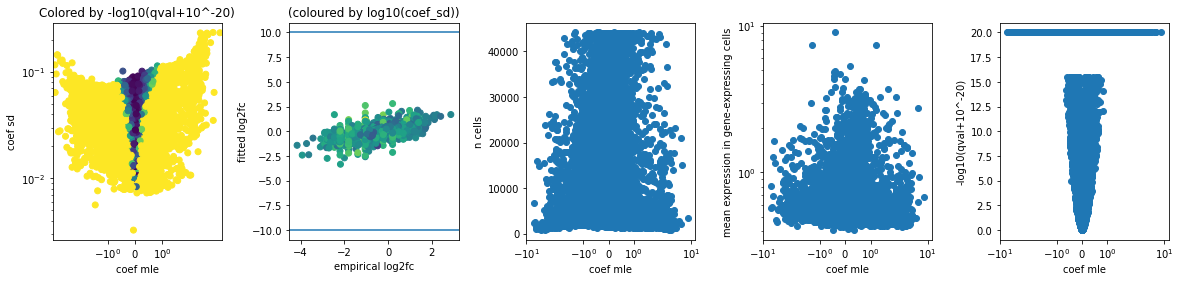

Min coef_sd: 0.003270941503488803


In [42]:
# Compare DE results of individual genes and expression characteristics
fig,ax=plt.subplots(1,5,figsize=(20,4))
plt.subplots_adjust(wspace=0.4)

ax[0].scatter(summary.coef_mle,summary.coef_sd,c=-np.log10(summary.qval+10**-20))
ax[0].set_xlabel('coef mle')
ax[0].set_ylabel('coef sd')
ax[0].set_yscale('log')
ax[0].set_xscale('symlog')
ax[0].set_title('Colored by -log10(qval+10^-20)')

ax[4].scatter(summary.coef_mle,-np.log10(summary.qval+10**(-20)))
ax[4].set_xlabel('coef mle')
ax[4].set_ylabel('-log10(qval+10^-20)')
ax[4].set_xscale('symlog')

if 'empirical_log2fc' in dir(result):
    ax[1].set_title('(coloured by log10(coef_sd))')
    # genes with nan empirical lfc will not be shown
    ax[1].scatter(x=result.empirical_log2fc.values,y=summary.log2fc,
                c=np.log10(summary.coef_sd))
    ax[1].set_xlabel('empirical log2fc')
    ax[1].set_ylabel('fitted log2fc')
    #ax[1].set_yscale('symlog')
    ax[1].axhline(10)
    ax[1].axhline(-10)

ax[2].scatter(summary.coef_mle,n_cells[summary.gene])
ax[2].set_xlabel('coef mle')
ax[2].set_ylabel('n cells')
ax[2].set_xscale('symlog')

ax[3].scatter(summary.coef_mle,mean_expr_in_expr_cells[summary.gene])
ax[3].set_xlabel('coef mle')
ax[3].set_ylabel('mean expression in gene-expressing cells')
ax[3].set_xscale('symlog')
ax[3].set_yscale('log')

display(fig)
plt.close()
print('Min coef_sd:',summary.coef_sd.min())

In [43]:
print('Min coef_sd:',summary.coef_sd.min())
#Min coef_sd: 0.003270941503488803

Min coef_sd: 0.003270941503488803


C: All genes could be fitted with a reasonable SD

In [44]:
# Add gene symbols as index
summary['EID']=summary.index
summary.index=adata_b_rn_sub.var.loc[summary.index,'gene_symbol']

In [53]:
# Save summary table for sharing
if True:
    summary.to_csv(
        path_save+'healthyDiseased_minCellsRatio'+str(min_cells_ratio)+'_summary.tsv',
    sep='\t')

### Check top genes

Expected DE genes

In [52]:
# Expected DE genes
summary.loc[['Ucn3','Mafa','Ins1','Ins2','Gc','Cck','Cd81','Rbp4','Mafb'],:]

gene          pval          qval    log2fc  \
gene_symbol                                                             
Ucn3         ENSMUSG00000044988  0.000000e+00  0.000000e+00 -1.862447   
Mafa         ENSMUSG00000047591  0.000000e+00  0.000000e+00 -3.884644   
Ins1         ENSMUSG00000035804  0.000000e+00  0.000000e+00 -1.322839   
Ins2         ENSMUSG00000000215  0.000000e+00  0.000000e+00 -0.386851   
Gc           ENSMUSG00000035540  0.000000e+00  0.000000e+00  3.012924   
Cck          ENSMUSG00000032532  0.000000e+00  0.000000e+00  6.171113   
Cd81         ENSMUSG00000037706  0.000000e+00  0.000000e+00  1.940601   
Rbp4         ENSMUSG00000024990  0.000000e+00  0.000000e+00  2.242535   
Mafb         ENSMUSG00000074622  3.154987e-11  4.268287e-11 -0.419832   

                     mean  zero_mean          grad  coef_mle   coef_sd  \
gene_symbol                                                              
Ucn3             3.997192      False  4.741739e-07 -1.862447  0.015448   
Mafa             3.663556      False  9.999164e-07 -3.884644  0.019598   
Ins1          4517.117002      False  5.427911e-07 -1.322839  0.014276   
Ins2         14911.066043      False  1.243089e-06 -0.386851  0.009716   
Gc               6.215229      False  1.410376e-06  3.012924  0.017812   
Cck             29.321700      False  1.026539e-06  6.171113  0.035050   
Cd81             6.288293      False  4.523195e-07  1.940601  0.017383   
Rbp4             1.399225      False  1.602414e-06  2.242535  0.044471   
Mafb             0.129776      False  1.805690e-07 -0.419832  0.063236   

                        ll                 EID  
gene_symbol                                     
Ucn3        -103866.583301  ENSMUSG00000044988  
Mafa         -83615.484786  ENSMUSG00000047591  
Ins1        -409941.107254  ENSMUSG00000035804  
Ins2        -460837.607429  ENSMUSG00000000215  
Gc          -107847.989555  ENSMUSG00000035540  
Cck         -121447.366136  ENSMUSG00000032532  
Cd81        -118691.289978  ENSMUSG00000037706  
Rbp4         -46886.744145  ENSMUSG00000024990  
Mafb         -15976.762156  ENSMUSG00000074622

Expression of top DE genes

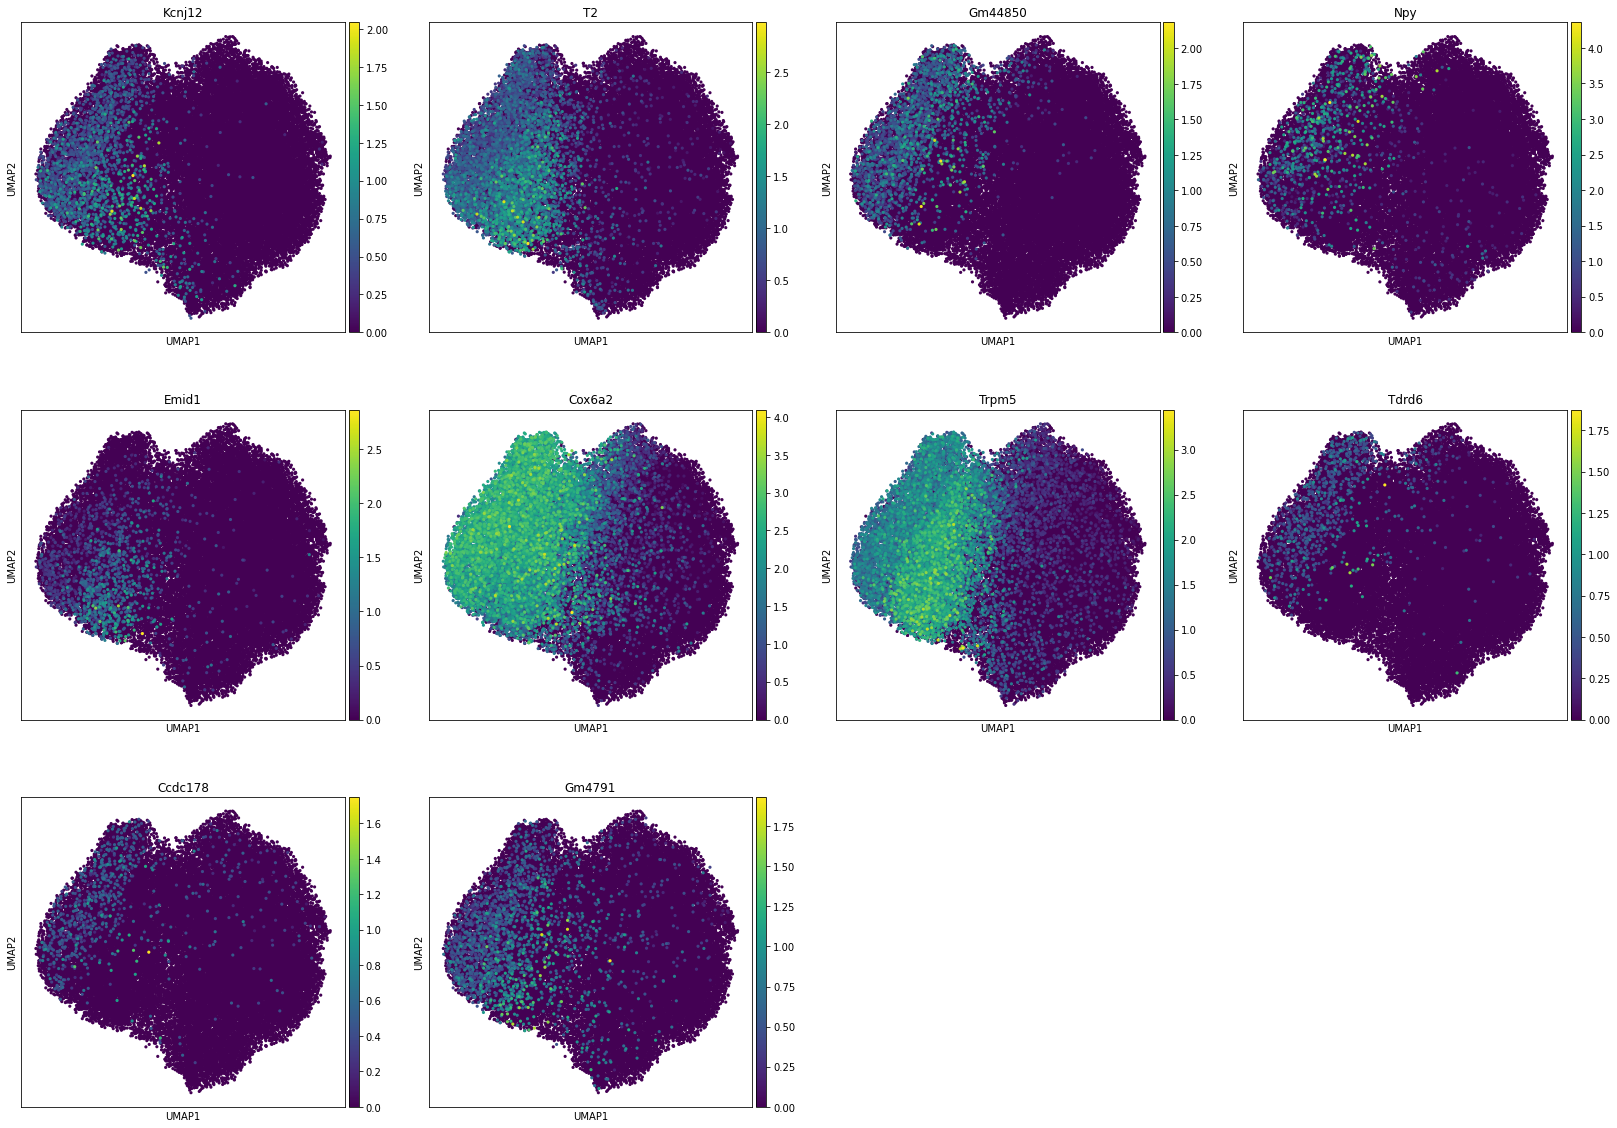

In [47]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_b_rn_sub,
           color=summary.sort_values(['coef_mle']).index[:10],gene_symbols='gene_symbol',
           s=40)

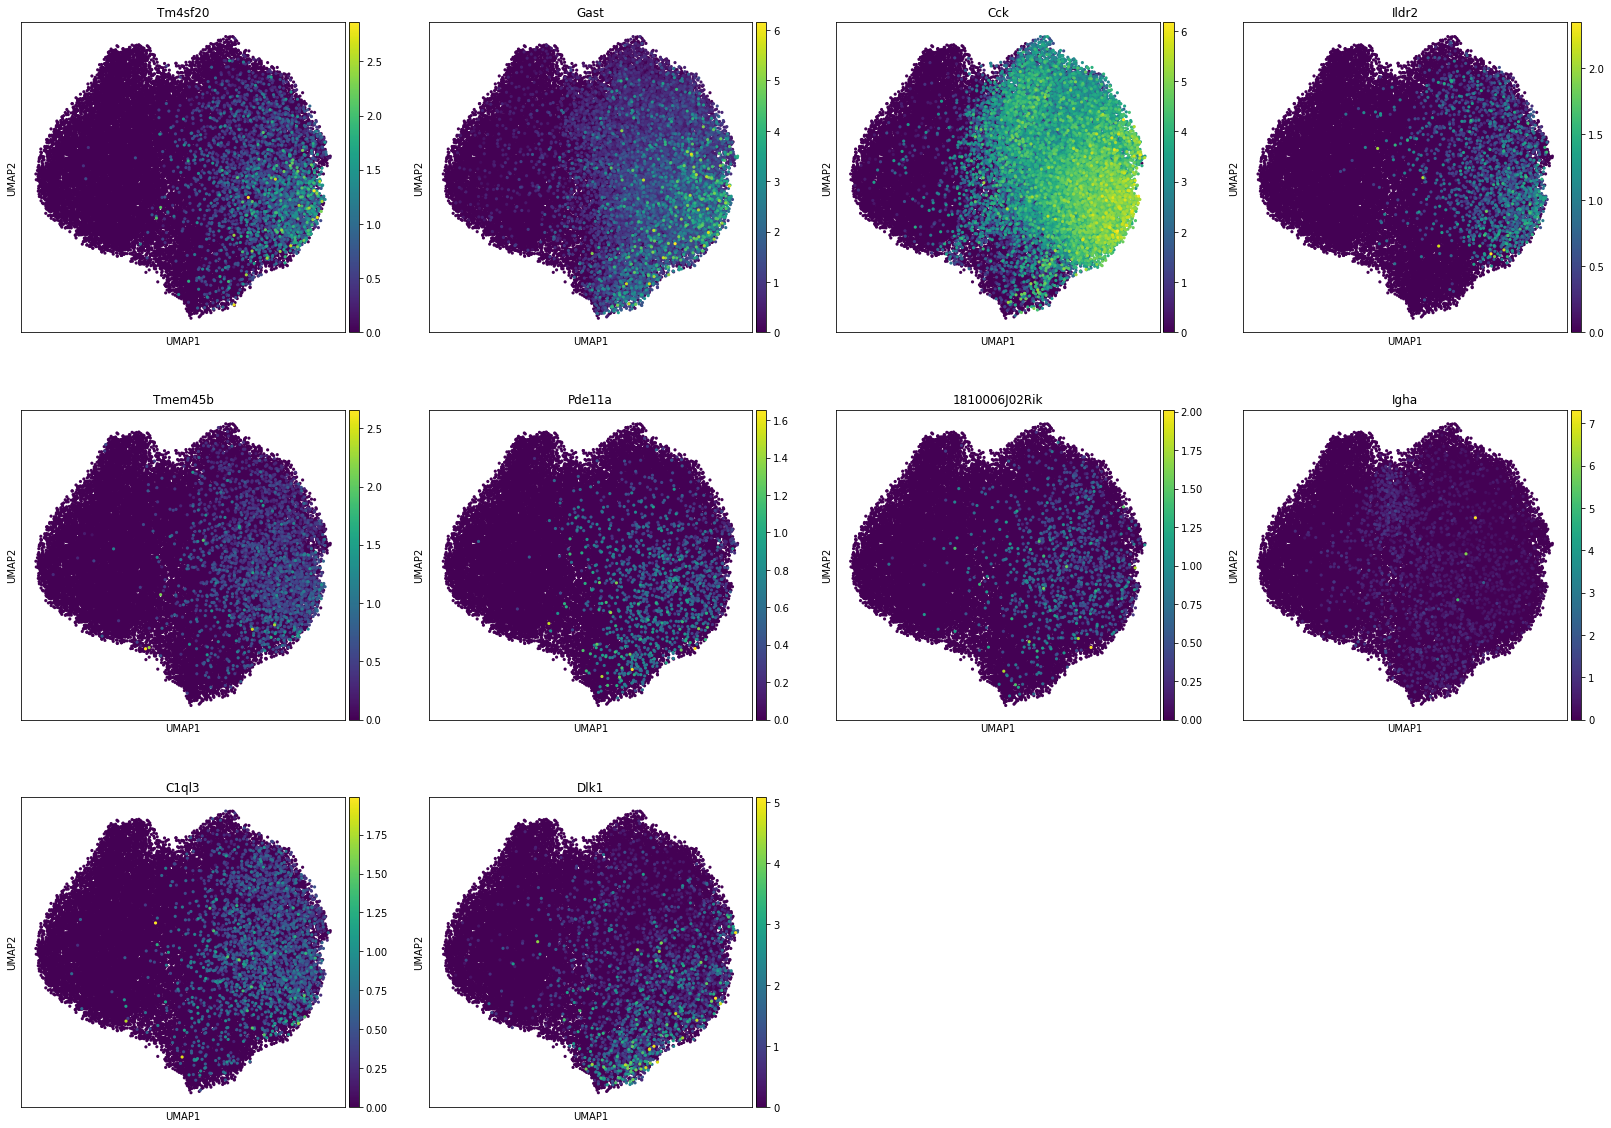

In [49]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_b_rn_sub,
           color=summary.sort_values(
               ['coef_mle'],ascending=[False]).index[:10],gene_symbols='gene_symbol',
           s=40)

### N DE genes

N DE genes at different thresholds

In [50]:
for fdr,lfc in [(0.05,1),(0.05,2),(0.01,1.5),(0.01,2),(0.01,2.5),(0.01,3),(0.01,4),(0.001,2),(10**-19,2)]:
    print('fdr %.2e, abs(lfc) > %.1f up %i down %i'%
          (fdr,lfc,summary.query('qval<@fdr & log2fc>@lfc').shape[0],
           summary.query('qval<@fdr & log2fc<-@lfc').shape[0]))

fdr 5.00e-02, abs(lfc) > 1.0 up 591 down 905
fdr 5.00e-02, abs(lfc) > 2.0 up 229 down 170
fdr 1.00e-02, abs(lfc) > 1.5 up 367 down 341
fdr 1.00e-02, abs(lfc) > 2.0 up 229 down 170
fdr 1.00e-02, abs(lfc) > 2.5 up 136 down 93
fdr 1.00e-02, abs(lfc) > 3.0 up 72 down 46
fdr 1.00e-02, abs(lfc) > 4.0 up 20 down 15
fdr 1.00e-03, abs(lfc) > 2.0 up 229 down 170
fdr 1.00e-19, abs(lfc) > 2.0 up 229 down 170


C: All genes with high lfc are significant.

LFC distn

Text(0.5, 0, 'log2fc')

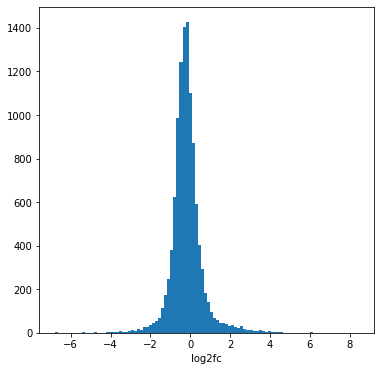

In [51]:
# LFC distn
plt.hist(summary.log2fc,bins=100)
plt.xlabel('log2fc')